<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml0826/blob/main/transfer_%E4%B8%8A%E8%AA%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
path = "/content/drive/MyDrive/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

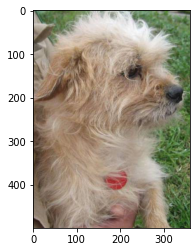

In [7]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[2000]))

In [8]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})
validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})
test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [12]:
import numpy as np

In [13]:
(np.array([[1, 2], [3, 4]]) + np.array([[5, 6], [7, 8]])) * 0.5

array([[3., 4.],
       [5., 6.]])

In [14]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
fs = glob.glob("train/*")
target = fs[20]

# 預處理(要照你偷來的模型做)
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(target).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img))
print(img_np)

[[[ -9.939003   -14.778999   -22.68      ]
  [ -6.939003   -11.778999   -19.68      ]
  [ -5.939003   -10.778999   -18.68      ]
  ...
  [ 36.060997    28.221       19.32      ]
  [ 35.060997    27.221       18.32      ]
  [ 36.060997    28.221       19.32      ]]

 [[ -7.939003   -12.778999   -20.68      ]
  [ -5.939003   -10.778999   -18.68      ]
  [ -4.939003    -9.778999   -17.68      ]
  ...
  [ 36.060997    28.221       19.32      ]
  [ 36.060997    28.221       19.32      ]
  [ 37.060997    29.221       20.32      ]]

 [[ -5.939003   -10.778999   -18.68      ]
  [ -4.939003    -9.778999   -17.68      ]
  [ -4.939003    -9.778999   -17.68      ]
  ...
  [ 41.060997    33.221       24.32      ]
  [ 41.060997    33.221       24.32      ]
  [ 42.060997    34.221       25.32      ]]

 ...

 [[  1.060997   -16.779      -26.68      ]
  [  0.06099701 -17.779      -27.68      ]
  [  0.06099701 -17.779      -27.68      ]
  ...
  [ 12.060997     7.2210007   -0.6800003 ]
  [ 18.060997    1

In [15]:
# 不用fit: fit_generator/自己寫
from functools import lru_cache
@lru_cache(maxsize=None)
def fib(n):
  if n == 0:
    return 0
  elif n == 1:
    return 1
  else:
    ans = fib(n-1) + fib(n-2)
    return ans
fib(200)

280571172992510140037611932413038677189525

In [16]:
# 自己寫training/validate
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [17]:
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
def get_data(x, y, batch=None):
    # 如果不是None, 那代表是數字(20), 隨機20個idx
    # 如果是None, 那就沒有隨機, 拿全部
    if batch is not None:
        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]
    # img_pre: preprocess過後的圖片
    # img_ori: 沒有preprocess的圖片
    img_pre, img_ori = [], []
    # 走過我的每一個path
    for p in x:
        # 讀取圖片並且預處理
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    # 回傳(預處理過後圖片, 沒處理圖片, 答案)
    return (np.array(img_pre), np.array(img_ori), y)
# 使用範例
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [18]:
# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [22]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [0.056752730160951614, 1.0]
validate: [0.14870533347129822, 0.9399999976158142]
--------------- 0 end ---------------
train: [0.22358205914497375, 0.949999988079071]
validate: [0.1479572057723999, 0.9399999976158142]
--------------- 1 end ---------------
train: [0.17889873683452606, 0.8999999761581421]
validate: [0.14744096994400024, 0.9399999976158142]
--------------- 2 end ---------------
train: [0.11204614490270615, 1.0]
validate: [0.14712390303611755, 0.9399999976158142]
--------------- 3 end ---------------
train: [0.2273217886686325, 0.8999999761581421]
validate: [0.14691908657550812, 0.9399999976158142]
--------------- 4 end ---------------
train: [0.1155197024345398, 1.0]
validate: [0.1465541124343872, 0.9399999976158142]
--------------- 5 end ---------------
train: [0.15324977040290833, 0.949999988079071]
validate: [0.1458393633365631, 0.9399999976158142]
--------------- 6 end ---------------
train: [0.26670604944229126, 0.8500000238418579]
validate: [0.1449747681617736

In [ ]:
model.predict(x)

array([[0.04552266, 0.9544773 ],
       [0.03077627, 0.96922374],
       [0.97444624, 0.02555383],
       [0.01037704, 0.98962295],
       [0.0301684 , 0.9698316 ],
       [0.99086446, 0.00913556],
       [0.6513852 , 0.3486148 ],
       [0.96386933, 0.03613061],
       [0.9984674 , 0.00153261],
       [0.49047583, 0.50952417],
       [0.9350147 , 0.06498523],
       [0.29619995, 0.7038001 ],
       [0.08417953, 0.9158205 ],
       [0.35211915, 0.64788085],
       [0.99729806, 0.00270197],
       [0.9953412 , 0.00465879],
       [0.03626693, 0.963733  ],
       [0.6879824 , 0.31201756],
       [0.90011615, 0.09988387],
       [0.31408995, 0.68591   ]], dtype=float32)

In [23]:
pre = model.predict(xt).argmax(axis=1)
model.evaluate(xt, yt)

4/4 [==============================] - 1s 98ms/step - loss: 0.1050 - accuracy: 0.9900


[0.10496354848146439, 0.9900000095367432]

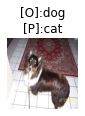

In [24]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != yt)[0]
idx = idx[:200]
pre_false_label = yt[idx]
pre_false_pre = pre[idx]
pre_false_img = xt_ori[idx]
# !
trans = ["dog", "cat"]
plt.figure(figsize=(15, 5))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

url:http://n.sinaimg.cn/sinakd10113/73/w500h373/20200503/fbf8-isyparh4669713.jpg
dog 的機率: 0.744
cat 的機率: 0.256


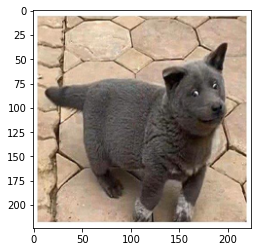

In [ ]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)